In [1]:
from pinntorch import *
from functools import partial
from matplotlib.transforms import Bbox

In [2]:
K = 5.0

In [3]:
def exact_solution_log(x):
    return 1/(1+torch.exp(-torch.Tensor(K*x)))

# exact solution in NumPy: This one is needed for the loss function becasue somehow the tensor form does not work as of now.
def exact_solution_log_np(x):
    return 1/(1+np.exp(-K*x))

def create_noisy_data(x, std_dev, noise_seed = 42):
    exact = exact_solution_log(x)
    torch.manual_seed(noise_seed)

    return exact + torch.randn(exact.size())*std_dev 

def data_loss(model: PINN, data: torch.Tensor = None, x: torch.Tensor = None) -> torch.float:
    # MSE loss 
    return (f(model, x) - data).pow(2).mean()

def physics_loss(model: PINN, x: torch.Tensor = None) -> torch.float:
    # define PDE loss
    #x = generate_sample(20, (-1.0, 1.0))
    pde_loss_pre = df(model, x) - K*f(model, x)*(1 - f(model, x))
    pde_loss = pde_loss_pre.pow(2).mean()
    
    # define conditional losses (initial + boundary)
    boundary_loss_right_pre = (f(model, at(+1.0)) - exact_solution_log_np(+1)) 
    boundary_loss_right = boundary_loss_right_pre.pow(2).mean()

    # combine all losses
    final_loss = pde_loss + boundary_loss_right
    
    return final_loss

def total_loss(model: PINN, data: torch.Tensor = None, x: torch.Tensor= None) -> list:

    """lists both data and physics loss for mgda to work"""

    loss_data = data_loss(model, data, x)

    loss_physics = physics_loss(model, x)

    return loss_data, loss_physics

In [4]:
def population_training(settings, input_data, train_points, val_points):

    L_p = []
    L_d = []
    L_VAL = []
    LR = []
    
    models_trained = []

    torch.manual_seed(settings['model_seed'])
    for i in range(settings['population_size']):
        print(i)
        loss_fn = partial(total_loss,data = input_data, x=train_points)  # For each alpha we need a loss function with different alpha. 
             
        model = PINN(1, 3, 9, 1)
        
        mgda = WeightMethods(
            method=getattr(Moo_method, "mgda"),
            n_tasks=2,
            # normalization=config.moo_normalization, # mgda
            device='cpu',
        )

        callbacks = [AllDataMonitor(
            partial(data_loss, data=input_data, x=train_points), 
            partial(physics_loss, x=train_points), 
            partial(physics_loss, x=val_points))]
        
        trained_model = train_model(
            model = model, 
            loss_fn=loss_fn,
            mo_method=mgda,
            max_epochs = settings['epochs'],
            lr_decay=2e-2,
            optimizer_fn = partial(torch.optim.Adam, lr=settings['start_learning_rate']),
            epoch_callbacks = callbacks
        )

        L_p.append(np.array(callbacks[0].physics_history))
        L_d.append(np.array(callbacks[0].data_history))
        LR.append(np.array(callbacks[0].lr_history))
        L_VAL.append(np.array(callbacks[0].val_history))
        models_trained.append(trained_model)

    return L_p, L_d, LR, L_VAL, models_trained

In [10]:
settings = {}

settings['n_data_points'] = 20
settings['n_train_points'] = 20
settings['n_val_points'] = 39
settings['noise_level'] = 0.1
settings['epochs'] = 10000
settings['population_size'] = 50
settings['noise_seed'] = 123
settings['model_seed'] = 333
settings['start_learning_rate'] = 0.01


training_points = generate_grid((settings['n_train_points']), (-1.0,1.0))
validation_points = generate_grid((settings['n_val_points']), (-1.0,1.0))

data_noise = create_noisy_data(training_points, settings['noise_level'], noise_seed=settings['noise_seed'])

Loss_physics, Loss_data, LR_evolution, Loss_val, models_trained = population_training(settings, data_noise, training_points, validation_points)

0
epoch: 1000	log10(loss sum): -1.8384	execution time (past 1k epochs): 8.2209
1
epoch: 1000	log10(loss sum): -1.8424	execution time (past 1k epochs): 8.0211
2
epoch: 1000	log10(loss sum): -1.8478	execution time (past 1k epochs): 8.1771
3
epoch: 1000	log10(loss sum): -1.8395	execution time (past 1k epochs): 7.9987
4
epoch: 1000	log10(loss sum): -1.8399	execution time (past 1k epochs): 8.1541
5
epoch: 1000	log10(loss sum): -1.8400	execution time (past 1k epochs): 8.0151
6
epoch: 1000	log10(loss sum): -1.8442	execution time (past 1k epochs): 8.0007
7
epoch: 1000	log10(loss sum): -1.8238	execution time (past 1k epochs): 7.9623
8
epoch: 1000	log10(loss sum): -1.8378	execution time (past 1k epochs): 8.2987
9
epoch: 1000	log10(loss sum): -1.8376	execution time (past 1k epochs): 8.3189
10
epoch: 1000	log10(loss sum): -1.8392	execution time (past 1k epochs): 8.5336
11
epoch: 1000	log10(loss sum): -1.8271	execution time (past 1k epochs): 8.2037
12
epoch: 1000	log10(loss sum): -1.8309	execution 

In [11]:
def identify_pareto(points):
    """
    Identify Pareto front indices in a set of points.
    :param points: An array of points.
    :return: Indices of points in the Pareto front.
    """
    population_size = points.shape[0]
    pareto_front = np.ones(population_size, dtype=bool)
    for i in range(population_size):
        for j in range(population_size):
            if all(points[j] <= points[i]) and any(points[j] < points[i]):
                pareto_front[i] = 0
                break
    return pareto_front

def plot_pareto_front(
    L_D,
    L_P,
    pareto_indices,
    xtick_rotation=0,
    file_name="pareto_plot",
    bbox_bounds=(0.1, -0.1, 5.2, 3.8),
    left_margin=0.15,
    bottom_margin=0.15,
    x_lim=None,
    y_lim=None,
):
    plt.figure(figsize=(5, 4))

    # Plot all points
    plt.scatter(L_D, L_P, color="gray", label="Dominated")  # Non-Pareto points in gray
    # Plot Pareto points in a different color
    plt.scatter(
        np.array(L_D)[pareto_indices],
        np.array(L_P)[pareto_indices],
        color="blue",
        label="Non-Dominated",
    )  # Pareto points in blue

    plt.ylabel(r"$\mathcal{L}_\mathrm{PHYSICS}$", loc="center", fontsize=13)
    plt.xlabel(r"$\mathcal{L}_\mathrm{DATA}$", loc="center", fontsize=13)
    plt.grid()

    # Set axis to use scientific notation
    plt.ticklabel_format(style="sci", axis="both", scilimits=(-2, 2))
    plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 1))
    plt.gca().yaxis.get_major_formatter().set_powerlimits((0, 1))

    plt.legend()

    # Optionally set x and y limits to zoom in
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)

    plt.subplots_adjust(left=left_margin, bottom=bottom_margin)

    bbox_instance = Bbox.from_bounds(*bbox_bounds)
    plt.xticks(rotation=xtick_rotation)

    #plt.savefig("plots/" + file_name + ".png", dpi=600)
    plt.show()
    
def find_last_threshold_index(physics, validation, threshold = 0.0):
    over = (validation - physics) > threshold
    reversed_arr = np.flipud(over)
    index = len(over) - np.where(reversed_arr == False)[0][0] - 1
    return index
    
def get_best_indices(physics, validation, threshold):
    best_indices = []
    for i in range(len(physics)):
        best_indices.append(find_last_threshold_index(physics[i], validation[i], threshold))
    return best_indices

In [12]:
#Loss_physics, Loss_data, LR_evolution, Loss_val, models_trained
log_physics = np.array(Loss_physics)
log_data = np.array(Loss_data)
log_val = np.array(Loss_val)

In [13]:
best_indices = get_best_indices(log_physics, log_val, 0.0)

pareto_physics = [log_physics[i][best_indices[i]] for i in range(len(log_physics))]
pareto_data = [log_data[i][best_indices[i]] for i in range(len(log_val))]

# determine non-dominated points
physics_data_points = np.array([(pareto_physics[i], pareto_data[i]) for i in range(len(pareto_physics))])
pareto_indices = identify_pareto(physics_data_points)

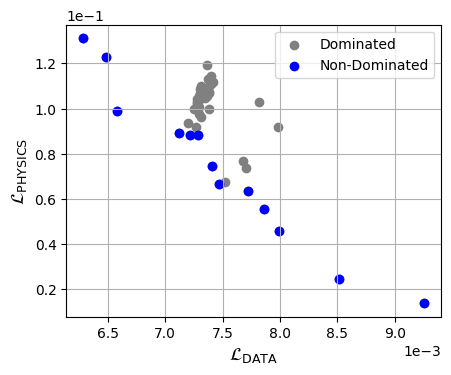

In [14]:
plot_pareto_front(pareto_data, pareto_physics, pareto_indices)